--- 1. Downloading Data for 10 Stocks ---
--- 2. Simulating Strategy (Long Top 3 Winners / Short Bottom 3 Losers) ---
--- 3. Generating Chart... ---
SUCCESS: Chart saved as 'momentum_chart.png'

Total Return: -12.72%
Sharpe Ratio: -0.01


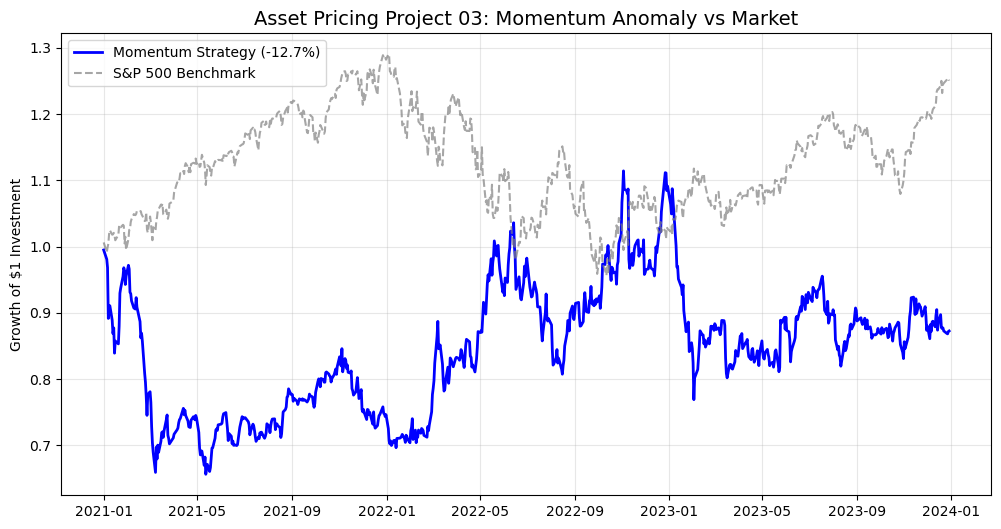

In [4]:
# =========================================================
# ASSET PRICING PROJECT 03: MOMENTUM STRATEGY
# Author: Fares Awwad-Zeidan
# Level: Advanced Asset Pricing (Anomaly Detection)
# =========================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# 1. SILENCE WARNINGS (Keeps output clean)
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 1. DEFINE THE UNIVERSE
# ==========================================
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 
           'JPM', 'BAC', 'XOM', 'CVX', 'PFE']
benchmark = '^GSPC'

START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

print(f"--- 1. Downloading Data for {len(tickers)} Stocks ---")

# Force auto_adjust=False to ensure consistent column names
raw_data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)
bench_data = yf.download(benchmark, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

# Safe Extract
if 'Adj Close' in raw_data.columns:
    data = raw_data['Adj Close']
else:
    data = raw_data['Close']

if 'Adj Close' in bench_data.columns:
    bench_index = bench_data['Adj Close']
else:
    bench_index = bench_data['Close']

# ==========================================
# 2. CALCULATE MOMENTUM
# ==========================================
momentum_window = 252 
momentum_scores = data.pct_change(momentum_window).dropna()

# ==========================================
# 3. RUN THE BACKTEST
# ==========================================
print("--- 2. Simulating Strategy (Long Top 3 Winners / Short Bottom 3 Losers) ---")

portfolio_returns = []
dates = []

monthly_dates = momentum_scores.resample('ME').first().index

for date in monthly_dates:
    try:
        idx = momentum_scores.index.get_indexer([date], method='nearest')[0]
        current_scores = momentum_scores.iloc[idx]
        
        sorted_scores = current_scores.sort_values(ascending=False)
        winners = sorted_scores.index[:3]
        losers = sorted_scores.index[-3:]
        
        start_next = date
        end_next = date + pd.DateOffset(months=1)
        
        daily_rets = data.pct_change().loc[start_next:end_next]
        
        if daily_rets.empty: continue
            
        long_leg = daily_rets[winners].mean(axis=1)
        short_leg = daily_rets[losers].mean(axis=1)
        strat_ret = long_leg - short_leg # Dollar Neutral
        
        portfolio_returns.extend(strat_ret.values)
        dates.extend(strat_ret.index)
        
    except Exception:
        continue

strategy_curve = pd.Series(portfolio_returns, index=dates).fillna(0)
strategy_curve = strategy_curve[~strategy_curve.index.duplicated(keep='first')]

# ==========================================
# 4. BENCHMARK COMPARISON
# ==========================================
bench_curve = bench_index.pct_change().loc[strategy_curve.index].fillna(0)

cum_strat = (1 + strategy_curve).cumprod()
cum_bench = (1 + bench_curve).cumprod()

# ==========================================
# 5. SAVE RESULT
# ==========================================
total_return = (cum_strat.iloc[-1] - 1) * 100
sharpe_ratio = strategy_curve.mean() / strategy_curve.std() * np.sqrt(252)

print(f"--- 3. Generating Chart... ---")
plt.figure(figsize=(12, 6))
plt.plot(cum_strat, label=f'Momentum Strategy ({total_return:.1f}%)', color='blue', linewidth=2)
plt.plot(cum_bench, label='S&P 500 Benchmark', color='gray', linestyle='--', alpha=0.7)

plt.title('Asset Pricing Project 03: Momentum Anomaly vs Market', fontsize=14)
plt.ylabel('Growth of $1 Investment')
plt.legend()
plt.grid(True, alpha=0.3)

# Save file automatically
plt.savefig("momentum_chart.png")
print("SUCCESS: Chart saved as 'momentum_chart.png'")

print("\n" + "="*50)
print(f"Total Return: {total_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print("="*50)